## Dataset from DATA.GOV
Link : https://catalog.data.gov/dataset/air-quality/resource/f3ed1638-92da-4f88-bb6b-7d3940514574

## Importing Libraries


In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score
from scipy.stats import uniform, randint

 1 Explore Data Analysis (EDA)
 Load the dataset and 

In [12]:
url = "https://data.cityofnewyork.us/api/views/c3uy-2p5r/rows.csv"
data = pd.read_csv(url)

# Display dataset structure
print(data.head())
print(data.info())
print(data.describe())

   Unique ID  Indicator ID                                   Name  \
0     179772           640  Boiler Emissions- Total SO2 Emissions   
1     179785           640  Boiler Emissions- Total SO2 Emissions   
2     178540           365                Fine particles (PM 2.5)   
3     178561           365                Fine particles (PM 2.5)   
4     823217           365                Fine particles (PM 2.5)   

          Measure Measure Info Geo Type Name  Geo Join ID  \
0  Number per km2       number         UHF42        409.0   
1  Number per km2       number         UHF42        209.0   
2            Mean       mcg/m3         UHF42        209.0   
3            Mean       mcg/m3         UHF42        409.0   
4            Mean       mcg/m3         UHF42        409.0   

            Geo Place Name          Time Period  Start_Date  Data Value  \
0         Southeast Queens                 2015  01/01/2015         0.3   
1  Bensonhurst - Bay Ridge                 2015  01/01/2015         

2 Data Cleaning and Preprocessing


In [13]:
# a. Handling missing values: Drop rows with missing 'Geo Join ID' or 'Data Value'
data = data.dropna(subset=['Geo Join ID', 'Data Value'])

# b. Converting 'Start_Date' to datetime format
data['Start_Date'] = pd.to_datetime(data['Start_Date'], format='%m/%d/%Y')

# c. Remove irrelevant columns
# Drop the 'Message' and 'Indicator ID' columns as these don't contribute to the model
data = data.drop(columns=['Message', 'Indicator ID'])

# X: Select all columns except 'Data Value' (target)
X = data.drop(columns=['Data Value'])  
y = data['Data Value']

print(X.head())
print(y.head())

   Unique ID                                   Name         Measure  \
0     179772  Boiler Emissions- Total SO2 Emissions  Number per km2   
1     179785  Boiler Emissions- Total SO2 Emissions  Number per km2   
2     178540                Fine particles (PM 2.5)            Mean   
3     178561                Fine particles (PM 2.5)            Mean   
4     823217                Fine particles (PM 2.5)            Mean   

  Measure Info Geo Type Name  Geo Join ID           Geo Place Name  \
0       number         UHF42        409.0         Southeast Queens   
1       number         UHF42        209.0  Bensonhurst - Bay Ridge   
2       mcg/m3         UHF42        209.0  Bensonhurst - Bay Ridge   
3       mcg/m3         UHF42        409.0         Southeast Queens   
4       mcg/m3         UHF42        409.0         Southeast Queens   

           Time Period Start_Date  
0                 2015 2015-01-01  
1                 2015 2015-01-01  
2  Annual Average 2012 2011-12-01  
3  Annua

3 Data Visualization


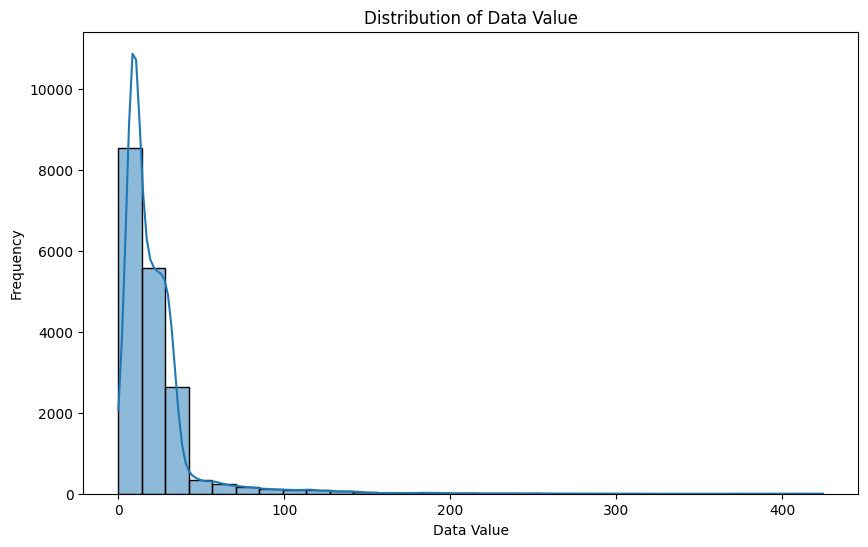

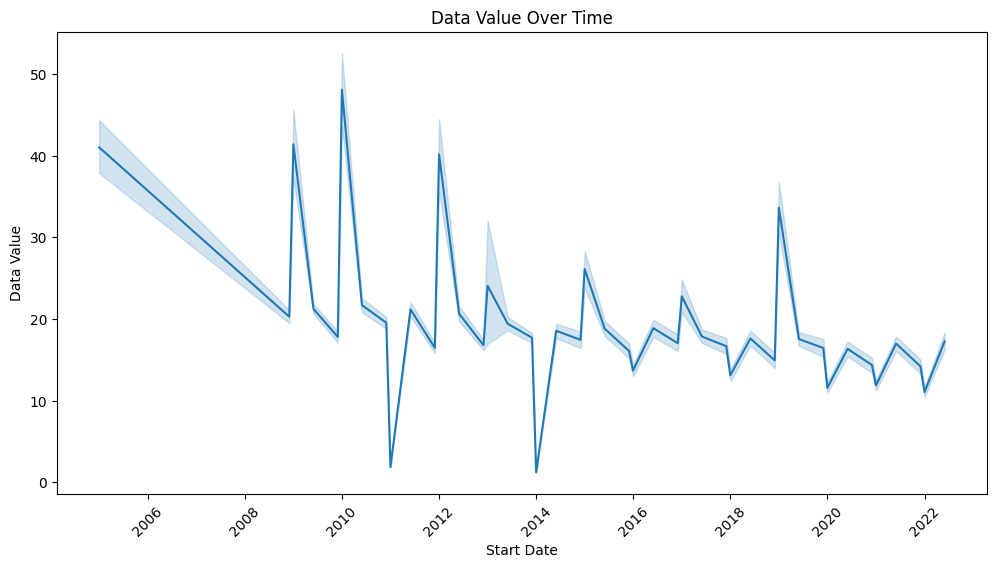

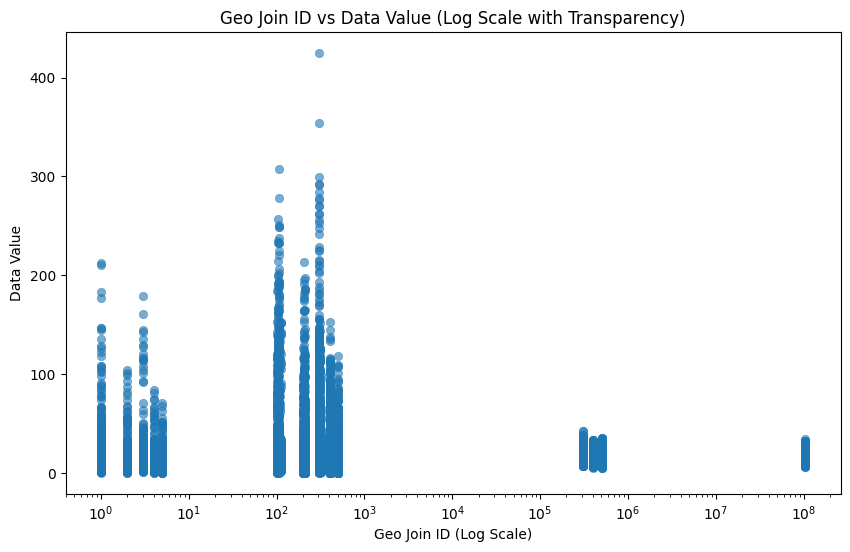

In [14]:
# a. Distribution of the target variable (Data Value)
plt.figure(figsize=(10, 6))
sns.histplot(data['Data Value'], bins=30, kde=True)
plt.title('Distribution of Data Value')
plt.xlabel('Data Value')
plt.ylabel('Frequency')
plt.show()

# b. Time series analysis of Data Value over Start_Date
plt.figure(figsize=(12, 6))
sns.lineplot(x='Start_Date', y='Data Value', data=data)
plt.title('Data Value Over Time')
plt.xlabel('Start Date')
plt.ylabel('Data Value')
plt.xticks(rotation=45)
plt.show()

# c. Bar plot to compare Data Value across different Geo Place Names
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Geo Join ID', y='Data Value', data=data, alpha=0.6, edgecolor=None)
plt.xscale('log')  # Keep log scale on x-axis
plt.title('Geo Join ID vs Data Value (Log Scale with Transparency)')
plt.xlabel('Geo Join ID (Log Scale)')
plt.ylabel('Data Value')
plt.show()

 4 Model Development


In [15]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessing
numeric_features = X_train.select_dtypes(include=['float64', 'int64']).columns
categorical_features = X_train.select_dtypes(include=['object']).columns

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Apply preprocessing
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

# Define models
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree Regressor': DecisionTreeRegressor(random_state=42),
    'Random Forest Regressor': RandomForestRegressor(random_state=42),
    'Gradient Boosting Regressor': GradientBoostingRegressor(random_state=42)
}

# Train and evaluate models
for name, model in models.items():
    model.fit(X_train_preprocessed, y_train)
    y_pred = model.predict(X_test_preprocessed)
    r2 = r2_score(y_test, y_pred)
    print(f'{name} R-squared: {r2:.4f}')

# Hyperparameter Tuning for Gradient Boosting Regressor using RandomizedSearchCV
param_dist = {
    'n_estimators': randint(100, 301),
    'max_depth': randint(3, 8),
    'learning_rate': uniform(0.01, 0.2),
    'subsample': uniform(0.8, 0.2)
}

random_search = RandomizedSearchCV(estimator=models['Gradient Boosting Regressor'], param_distributions=param_dist, 
                                   n_iter=50, scoring='r2', cv=5, random_state=42, n_jobs=-1)
random_search.fit(X_train_preprocessed, y_train)

best_gb_model = random_search.best_estimator_
y_pred_best_gb = best_gb_model.predict(X_test_preprocessed)
r2_best_gb = r2_score(y_test, y_pred_best_gb)
print(f'Best Gradient Boosting Regressor R-squared: {r2_best_gb:.4f}')

Linear Regression R-squared: 0.6192
Decision Tree Regressor R-squared: 0.8594
Random Forest Regressor R-squared: 0.9306
Gradient Boosting Regressor R-squared: 0.7508
Best Gradient Boosting Regressor R-squared: 0.9558


5 Model Evaluation

In [17]:
for name, model in models.items():
    model.fit(X_train_preprocessed, y_train)
    y_pred = model.predict(X_test_preprocessed)
    r2 = r2_score(y_test, y_pred)
    

print(f'Best Gradient Boosting Regressor R-squared: {r2_best_gb:.4f}')

Best Gradient Boosting Regressor R-squared: 0.9558
